# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/Progetto AN2DL

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1E-vTKoRQdfaM-gJ1ejZEYjDrQK6K2Mmu/Progetto AN2DL


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
from datetime import datetime

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import pandas as pd
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import cv2

from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from PIL import Image
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from imgaug import augmenters as aug
from imgaug.augmentables.segmaps import SegmentationMapOnImage
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras import regularizers, Model


# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

2.17.1
TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [ ]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 🔍 Inpesct Data

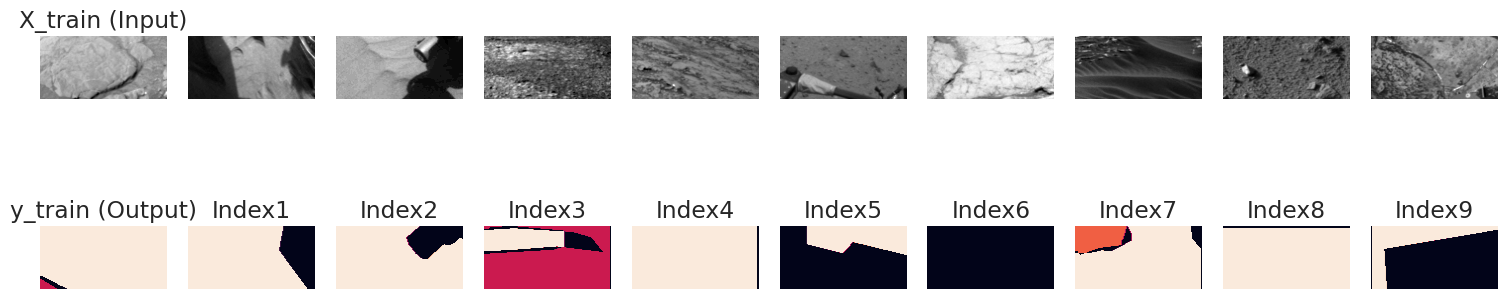

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 casual indices
num_samples = 10
random_indices = np.random.choice(len(X_train), num_samples, replace=False)

# Select 10 images
X_samples = X_train[random_indices]
y_samples = y_train[random_indices]

# Configue figure
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

# Show X_train images
for i, ax in enumerate(axes[0]):
    ax.imshow(X_samples[i], cmap='gray')
    ax.axis('off')

# Show y_train images
for i, ax in enumerate(axes[1]):
    ax.imshow(y_samples[i])
    ax.set_title(f'Index{i}')
    ax.axis('off')

# Add titles
axes[0][0].set_title("X_train (Input)")
axes[1][0].set_title("y_train (Output)")

plt.tight_layout()
plt.show()

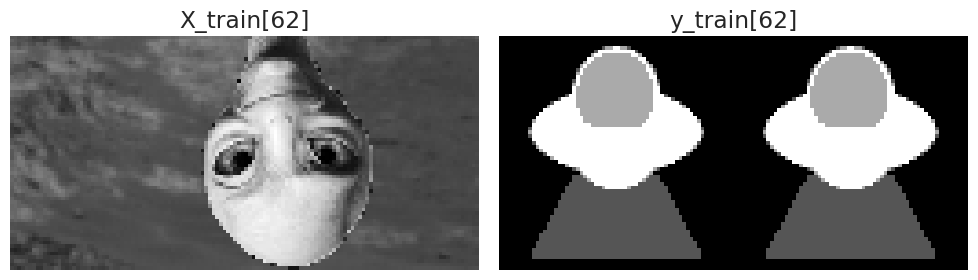

In [ ]:
import matplotlib.pyplot as plt

def display_image_by_index(index, X_train, y_train):
    """
    Visualizza un'immagine da X_train e la corrispondente immagine/etichetta da y_train.

    Args:
        index (int): Indice dell'immagine da visualizzare.
        X_train (numpy.ndarray): Dataset delle immagini di input.
        y_train (numpy.ndarray): Dataset delle etichette o immagini di output.
    """

    if index < 0 or index >= len(X_train):
        print(f"Indice {index} fuori dai limiti. Fornire un valore tra 0 e {len(X_train) - 1}.")
        return

    # Configuration of the image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show image in X_train
    axes[0].imshow(X_train[index], cmap='gray')
    axes[0].set_title(f"X_train[{index}]")
    axes[0].axis('off')

    # Show image and label y_train
    axes[1].imshow(y_train[index], cmap='gray')
    axes[1].set_title(f"y_train[{index}]")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


display_image_by_index(62, X_train, y_train)

## ❌ Eliminate Outliers

In [ ]:
def find_matching_indices(target_index, dataset):
    """
    Trova tutti gli indici nel dataset che contengono immagini uguali a quella di target_index.

    Args:
        target_index (int): Indice dell'immagine di riferimento.
        dataset (numpy.ndarray): Dataset delle immagini da confrontare.

    Returns:
        list: Lista di indici delle immagini uguali.
    """
    # Check if the index is correct
    if target_index < 0 or target_index >= len(dataset):
        print(f"Indice {target_index} fuori dai limiti. Fornire un valore tra 0 e {len(dataset) - 1}.")
        return []

    # Target image
    target_image = dataset[target_index]

    # Find indexes with the same image
    matching_indices = [idx for idx, img in enumerate(dataset) if np.array_equal(img, target_image)]

    return matching_indices


target_index = 62
matching_indices = find_matching_indices(target_index, y_train)

print(f"Gli indici delle immagini uguali a y_train[{target_index}] sono: {matching_indices}")


Gli indici delle immagini uguali a y_train[62] sono: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


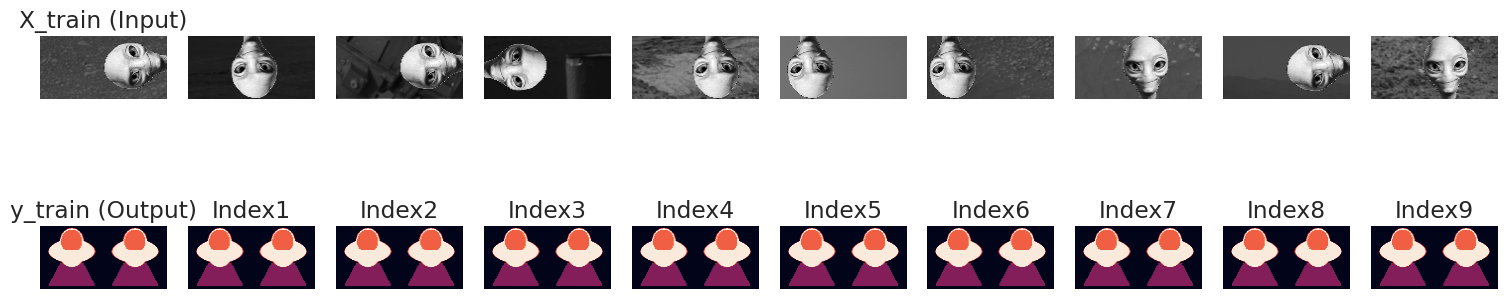

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 unique random indices
num_samples = 10
random_indices = np.random.choice(matching_indices, num_samples, replace=False)

# Select corresponding images and labels
X_samples = X_train[random_indices]
y_samples = y_train[random_indices]

# Set up the figure
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

# Display the images from X_train
for i, ax in enumerate(axes[0]):
    ax.imshow(X_samples[i], cmap='gray')
    ax.axis('off')

# Display the images or labels from y_train
for i, ax in enumerate(axes[1]):
    ax.imshow(y_samples[i])
    ax.set_title(f'Index{i}')
    ax.axis('off')

# Add optional titles
axes[0][0].set_title("X_train (Input)")
axes[1][0].set_title("y_train (Output)")

plt.tight_layout()
plt.show()

In [ ]:
print(f"Number of aliens: {len(matching_indices)}")

Number of aliens: 110


In [ ]:
# Create a list with the indices of non-duplicate images
all_indices = set(range(len(X_train)))
matching_indices = set(matching_indices)
unique_indices = list(all_indices - matching_indices)

# Create a new dataset without duplicates
X_filtered = X_train[unique_indices]
y_filtered = y_train[unique_indices]

# Check: display the dimensions of the original and deduplicated datasets
print(f"Original dimension of images: {X_train.shape}")
print(f"Dimension of images without duplicates: {X_filtered.shape}")
print(f"Original dimension of labels: {y_train.shape}")
print(f"Dimension of labesls without duplicates: {y_filtered.shape}")

Original dimension of images: (2615, 64, 128)
Dimension of images without duplicates: (2505, 64, 128)
Original dimension of labels: (2615, 64, 128)
Dimension of labesls without duplicates: (2505, 64, 128)


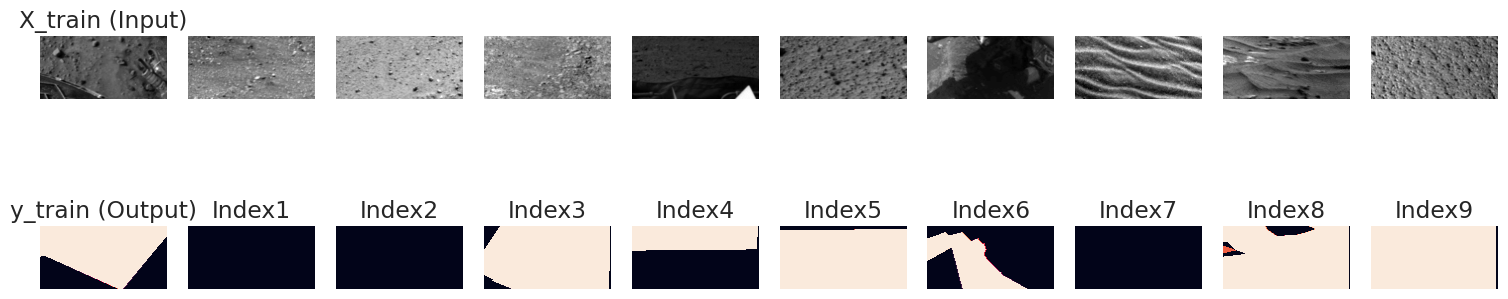

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 unique random indices
num_samples = 10
random_indices = np.random.choice(unique_indices, num_samples, replace=False)

# Select corresponding images and labels
X_samples = X_train[random_indices]
y_samples = y_train[random_indices]

# Set up the figure
fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

# Display the images from X_train
for i, ax in enumerate(axes[0]):
    ax.imshow(X_samples[i], cmap='gray')
    ax.axis('off')

# Display the images or labels from y_train
for i, ax in enumerate(axes[1]):
    ax.imshow(y_samples[i])
    ax.set_title(f'Index{i}')
    ax.axis('off')

# Add optional titles
axes[0][0].set_title("X_train (Input)")
axes[1][0].set_title("y_train (Output)")

plt.tight_layout()
plt.show()

In [ ]:
X_train = X_filtered
y_train = y_filtered

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


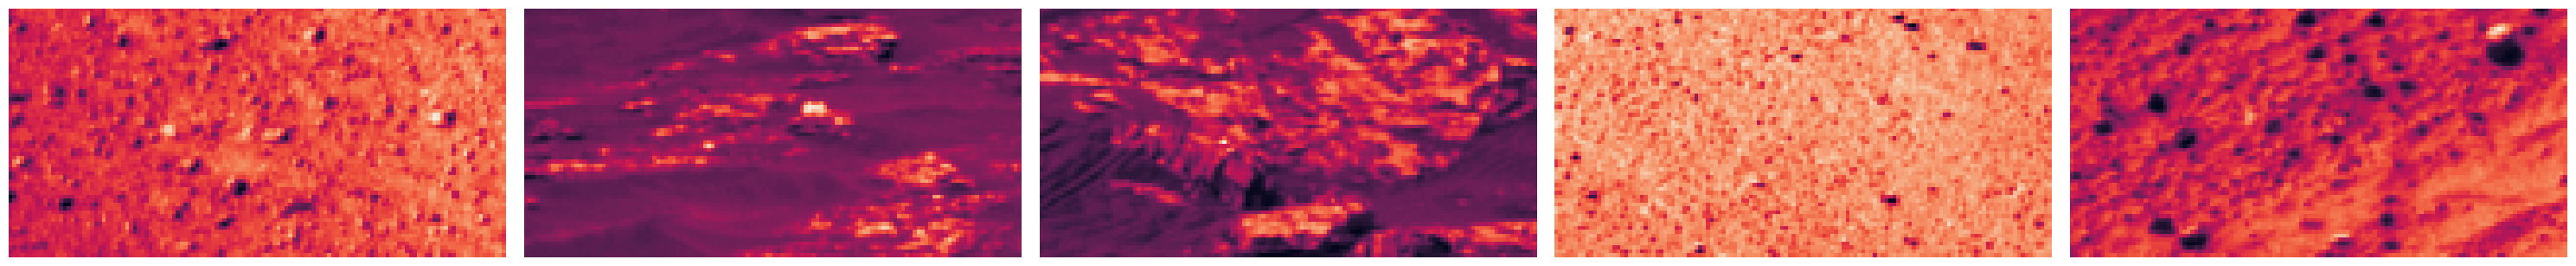

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate 10 unique random indices
num_samples = 5
random_indices = np.random.choice(len(X_train), num_samples, replace=False)

# Select corresponding images and labels
X_samples = X_train[random_indices]

# Set up the figure
fig, axes = plt.subplots(1, num_samples, figsize=(30, 10))

# Display the images from X_train
for i, ax in enumerate(axes):
    ax.imshow(X_samples[i])
    ax.axis('off')


plt.tight_layout()
plt.show()

## 🧮 Define Network Parameters

In [ ]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {X_train.shape}")
print(f"Number of classes: {num_classes}")
print(f"Unique labels: {X_test.shape}")
print(f"Unique labels: {y_train.shape}")

Input shape: (2505, 64, 128)
Number of classes: 5
Unique labels: (10022, 64, 128)
Unique labels: (2505, 64, 128)


In [ ]:
# Batch size for training
batch_size = 32

# Learning rate: step size for updating the model's weights
learning_rate = 1e-3

# Set early stopping patience threshold
patience = 30

# Set maximum number of training epochs
epochs = 150

# Kernel Size for Convolutional
kernel_size = 3

# Kernel Size for Upsampling
upsampling_size = (2, 2)

# Number of Filters
filters = 64

# Print the defined parameters
#print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Batch Size: 32
Learning Rare: 0.001


In [ ]:
# Split the paths (not the data) into training, validation, and test sets
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=seed
)

# Check the shape of the splits
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")
print("Data splitted!")


X_train shape: (2254, 64, 128), X_val shape: (251, 64, 128)
y_train shape: (2254, 64, 128), y_val shape: (251, 64, 128)
Data splitted!


## 🔄 Data processing

### 🆙 Augmentation Pipeline

In [ ]:
# augmentation pipeline
augmentation_pipeline = aug.Sequential([
    aug.Fliplr(0.5),
    aug.Flipud(0.5),
    aug.GammaContrast((0.5, 2.0)),
    aug.Sometimes(0.5, aug.Affine(
        rotate=(-20, 20),
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        scale={"x": (0.75, 1.5), "y": (0.75, 1.5)}
    ))
])

In [ ]:
# A couple of methods to make ImgAug pipelines batch and TF-compatible
def process_image_and_mask(image, mask, pipeline):
    segmap = SegmentationMapOnImage(mask, shape=image.shape)
    aug_image, aug_mask = pipeline(image=image, segmentation_maps=segmap)
    return aug_image, aug_mask.get_arr()

def tf_process(image, mask, pipeline):
    def image_process_fn(image, mask):
        aug_images = []
        aug_masks = []
        for img, msk in zip(image.numpy(), mask.numpy()):
            aug_img, aug_msk = process_image_and_mask(img, msk, pipeline)
            aug_images.append(aug_img)
            aug_masks.append(aug_msk)
        aug_images = np.array(aug_images)
        aug_masks = np.array(aug_masks)

        return aug_images, aug_masks

    if mask is None:
        mask = tf.squeeze(tf.zeros_like(image, dtype=tf.uint8), axis=-1)

    image_shape = image.shape
    mask_shape = mask.shape

    aug_images, aug_masks = tf.py_function(
        func=image_process_fn,
        inp=[image, mask],
        Tout=[tf.float32, tf.uint8]
    )

    aug_images.set_shape(image_shape)  # Set height, width, and channels
    aug_masks.set_shape(mask_shape)

    return aug_images, aug_masks

tf_augment = lambda X, y: tf_process(X, y, augmentation_pipeline) # augmentation mapping function


### 🍱 Make Datasets

In [ ]:
# Function to find an indes and print the image
def find_and_plot_class_images(X_train, y_train, class_id=4, num_images=10):
    """
    Trova gli indici delle immagini in y_train che contengono pixel della classe specificata
    e mostra un plot con un campione casuale di immagini e maschere.

    Args:
        X_train: Array di immagini di input.
        y_train: Array di maschere di segmentazione.
        class_id: La classe di interesse (default: 4).
        num_images: Numero di immagini da visualizzare (default: 10).
    """
    # Find the indices of images that contain pixels of the class `class_id`
    indices = [i for i, mask in enumerate(y_train) if class_id in mask]

    print(f"Numero totale di immagini con classe {class_id}: {len(indices)}")

    # If there are fewer images than the required number
    if len(indices) < num_images:
        print(f"Attenzione: ci sono solo {len(indices)} immagini disponibili. Mostrando tutte le immagini.")
        num_images = len(indices)

    plt.tight_layout()
    plt.show()

    return indices

In [ ]:
def load_single_image_from_array(image, label):
    """
    Load a single image and its corresponding label from the provided arrays.
    """
    # Normalize the image to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    # Add the channel dimension (height, width) -> (height, width, 1)
    image = tf.expand_dims(image, axis=-1)

    # Ensure labels are integers (e.g., 0, 1, 2, 3, 4 for class ids)
    label = tf.cast(label, tf.int32)  # Use int32 for category labels
    label = tf.expand_dims(label, axis=-1)  # Add channel dimension for label

    return image, label

def apply_category_mapping(label):
    """
    Apply category mapping to labels (if necessary).
    This is typically used for mapping label indices to new categories.
    """
    category_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}  # Placeholder mapping
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

import tensorflow as tf


def make_dataset(images, labels, batch_size, shuffle=False, augment=False, seed=seed, augment4=False):
    """
    Create a memory-efficient TensorFlow dataset from in-memory arrays.
    """
    # Create dataset from the images and labels (in-memory arrays)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels from the arrays
    dataset = dataset.map(
        load_single_image_from_array,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping to labels
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply data augmentation  if requested
    if augment:
        dataset = dataset.map(lambda X, y: tf_augment(X, y), num_parallel_calls=tf.data.AUTOTUNE)
    # Apply data augmentation  to increase the elements of class 4
    if augment4:
       # Find indices with class 4
        indices_with_class_4 = find_and_plot_class_images(images, labels, 4, 10)

        # Create a dataset
        class_4_dataset = tf.data.Dataset.from_tensor_slices(
            (np.take(images, indices_with_class_4, axis=0),
             np.take(labels, indices_with_class_4, axis=0))
        ).map(
            load_single_image_from_array,
            num_parallel_calls=tf.data.AUTOTUNE
        )

        # Apply data augmentation
        augmentation_factor = 1
        for i in range(augmentation_factor):

            augmented_class_4_dataset = class_4_dataset.map(
                lambda X, y: tf_augment(X, y), num_parallel_calls=tf.data.AUTOTUNE
            )

            # Correct the dataset
            dataset = dataset.map(
                lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.int32)),
                num_parallel_calls=tf.data.AUTOTUNE
            )

            # Corrct the dataset
            augmented_class_4_dataset = augmented_class_4_dataset.map(
                lambda x, y: (
                    tf.cast(x, tf.float32),  # Cambia immagine in float32
                    tf.cast(y, tf.int32)     # Cambia etichetta in int32
                ),
                num_parallel_calls=tf.data.AUTOTUNE
            )

            # Concatenate original dataset with the augmented
            dataset = dataset.concatenate(augmented_class_4_dataset)


    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Prefetch data for better performance during training
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    augment4=False,
    seed=seed
)

train_dataset = train_dataset.map(lambda X, y: tf_augment(X, y), num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

test_dataset = tf.cast(X_test, tf.float32) / 255.0

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break



Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'uint8'>


## 🧙 Auxiliary Functions

### 🏋 Class Weights

Class Ratios (Pixel/Mask): {0.0: 0.24415795530168588, 1.0: 0.3389894744412711, 2.0: 0.23458144721883317, 3.0: 0.1808789040837123, 4.0: 0.00139221895449756}
Class Weights (Standard - Pixel/Mask): {0.0: 0, 1.0: 2.949944099734126, 2.0: 4.2629117172558555, 3.0: 5.528560696813994, 4.0: 718.2778231610067}
Class Weights (Normalized - Pixel/Mask): {0.0: 0, 1.0: 0.004035385034525754, 2.0: 0.005831463094120731, 3.0: 0.007562811478495886, 4.0: 0.9825703403928576}
Somma dei pesi normalizzati: 1.0


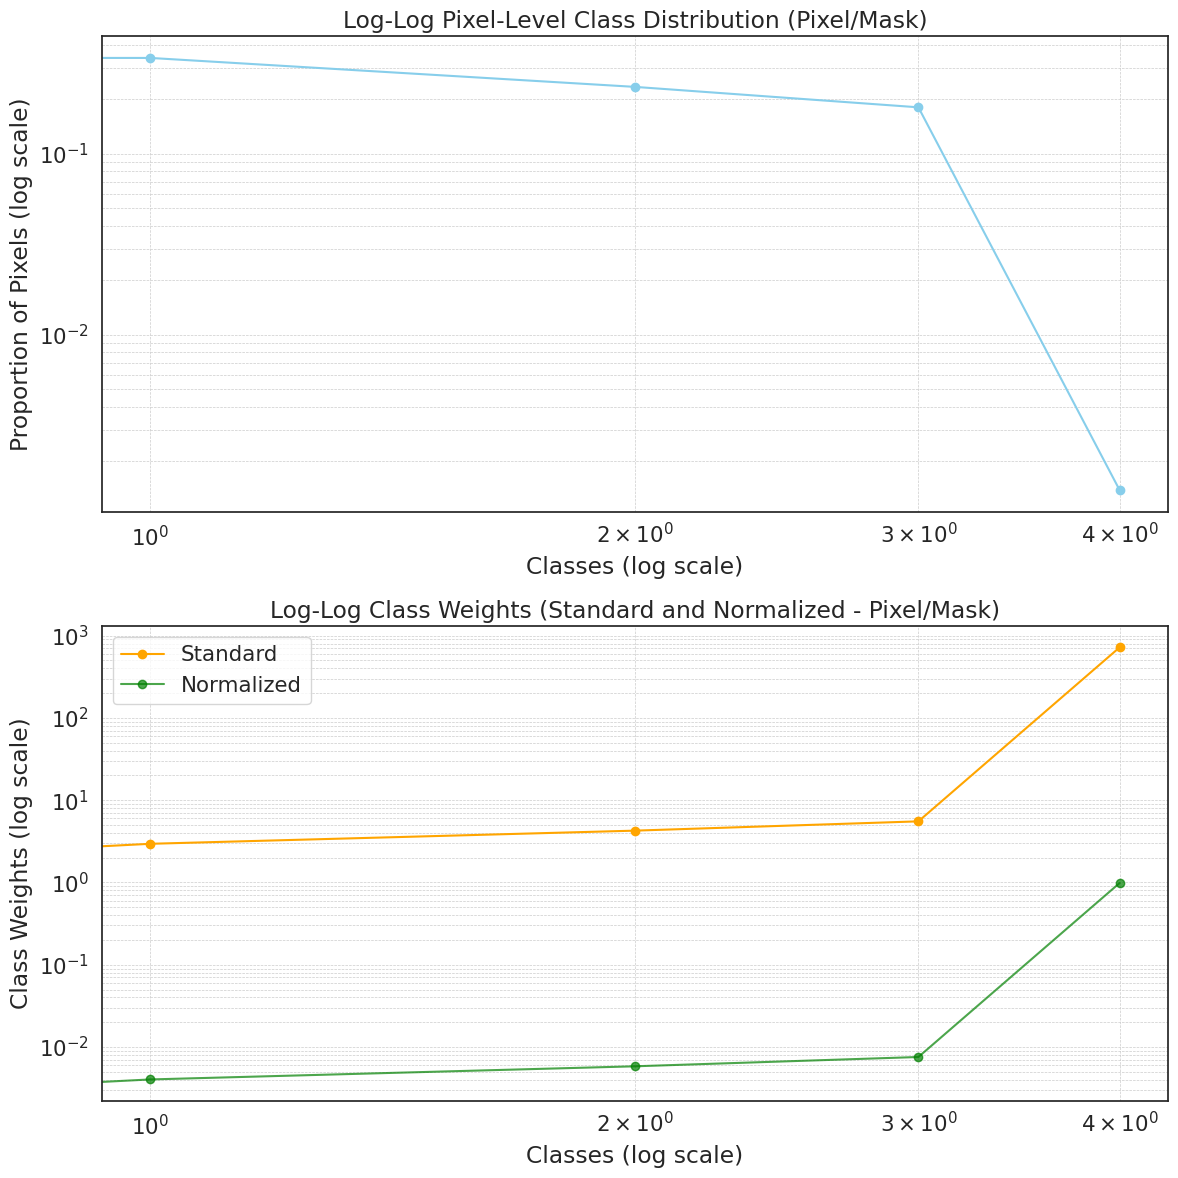

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to count the pixels per class
class_pixel_count = defaultdict(int)
total_pixels_count = 0  # Totale dei pixel su tutte le maschere

# Iterate through each mask in y_train
for mask in y_train:
    unique, counts = np.unique(mask, return_counts=True)  # Pixels per class in the mask
    for cls, count in zip(unique, counts):
        class_pixel_count[cls] += count  # Sum the pixels per class
    total_pixels_count += mask.size  # Aggiornare il totale dei pixel

# Calculate the pixel-to-mask ratio for each class
class_ratios_pixel_mask = {cls: count / total_pixels_count for cls, count in class_pixel_count.items()}

# Compute the class weights (standard)
class_weights_standard_pixel_mask = {
    cls: 0 if cls == 0 else total_pixels_count / count for cls, count in class_pixel_count.items()
}

# Normalize the weights so that the sum equals 1
total_weight_standard = sum(class_weights_standard_pixel_mask.values())
class_weights_normalized_pixel_mask = {
    cls: 0 if cls == 0 else weight / total_weight_standard for cls, weight in class_weights_standard_pixel_mask.items()
}

# Check that the sum of normalized weights is equal to 1
sum_normalized_weights = sum(class_weights_normalized_pixel_mask.values())
assert abs(sum_normalized_weights - 1.0) < 1e-6, "La somma dei pesi normalizzati non è pari a 1!"

# Print the results
print("Class Ratios (Pixel/Mask):", class_ratios_pixel_mask)
print("Class Weights (Standard - Pixel/Mask):", class_weights_standard_pixel_mask)
print("Class Weights (Normalized - Pixel/Mask):", class_weights_normalized_pixel_mask)
print("Somma dei pesi normalizzati:", sum_normalized_weights)

# Visualize the distributions
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Pixel-to-mask ratio (log-log)
ax[0].loglog(class_ratios_pixel_mask.keys(), class_ratios_pixel_mask.values(), 'o-', color='skyblue')
ax[0].set_xlabel('Classes (log scale)')
ax[0].set_ylabel('Proportion of Pixels (log scale)')
ax[0].set_title('Log-Log Pixel-Level Class Distribution (Pixel/Mask)')
ax[0].grid(True, which="both", linestyle="--", linewidth=0.5)

# Class weights based on pixel/mask (log-log)
ax[1].loglog(class_weights_standard_pixel_mask.keys(), class_weights_standard_pixel_mask.values(), 'o-', color='orange', label='Standard')
ax[1].loglog(class_weights_normalized_pixel_mask.keys(), class_weights_normalized_pixel_mask.values(), 'o-', color='green', label='Normalized', alpha=0.7)
ax[1].set_xlabel('Classes (log scale)')
ax[1].set_ylabel('Class Weights (log scale)')
ax[1].set_title('Log-Log Class Weights (Standard and Normalized - Pixel/Mask)')
ax[1].legend()
ax[1].grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

class_weights = [0, 1, 1, 1, 1]


In [ ]:
# Print chosen Class Weights
print("Class Weights:", class_weights)

Class Weights: [0, 1, 1, 1, 1]


### 💻 Custom Loss

In [ ]:
import tensorflow as tf

# Costanti per i pesi delle perdite
SCCE_WEIGHT = 1  # Peso per Sparse Categorical Cross-Entropy
DICE_WEIGHT = 0   # Peso per Dice Loss
BOUNDARY_WEIGHT = 0  # Peso per Boundary Loss

def weighted_sparse_categorical_crossentropy(class_weights):
    """
    Sparse Categorical Cross-Entropy con pesi per classe.
    """
    def loss(y_true, y_pred):
        # Convertire class weights in un tensore
        weights = tf.constant([class_weights[i] for i in range(len(class_weights))], dtype=tf.float32)

        # Calcolare i pesi per ciascun pixel
        sample_weights = tf.gather(weights, tf.cast(y_true, tf.int32))

        # Calcolare la Sparse Categorical Cross-Entropy per ogni pixel
        scce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Applicare i pesi alla loss
        weighted_loss = scce * sample_weights
        return tf.reduce_mean(weighted_loss)  # Media ponderata
    return loss

def weighted_dice_loss(class_weights, num_classes):
    """
    Dice Loss con pesi per classe.
    """
    def loss(y_true, y_pred):
        # One-hot encoding per y_true
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)

        # Calcolo del numeratore e del denominatore per ogni classe
        intersection = tf.reduce_sum(y_pred * y_true_one_hot, axis=[0, 1, 2])
        union = tf.reduce_sum(y_pred + y_true_one_hot, axis=[0, 1, 2])

        # Calcolo della Dice Loss
        dice = (2. * intersection + 1e-7) / (union + 1e-7)
        dice_loss = 1 - dice

        # Applicare i pesi
        weights = tf.constant([class_weights[i] for i in range(len(class_weights))], dtype=tf.float32)
        weighted_loss = dice_loss * weights
        return tf.reduce_mean(weighted_loss)
    return loss

def boundary_loss(y_true, y_pred):
    """
    Boundary Loss basata sul confronto dei bordi con Sobel.
    """
    # Espandi la dimensione di y_true e y_pred per avere 4 dimensioni
    if len(y_true.shape) == 3:
        y_true = tf.expand_dims(y_true, axis=-1)
    if len(y_pred.shape) == 3:
        y_pred = tf.expand_dims(y_pred, axis=-1)

    # Calcola i bordi
    y_true_edges = tf.image.sobel_edges(tf.cast(y_true, tf.float32))
    y_pred_edges = tf.image.sobel_edges(tf.cast(y_pred, tf.float32))

    # Calcola la perdita come la differenza assoluta dei bordi
    loss = tf.reduce_mean(tf.abs(y_true_edges - y_pred_edges))
    return loss

def custom_loss(class_weights, num_classes):
    """
    Funzione di perdita combinata con SCCE, Dice Loss e Boundary Loss.
    """
    # Definizione delle singole funzioni di perdita
    scce_loss_fn = weighted_sparse_categorical_crossentropy(class_weights)
    dice_loss_fn = weighted_dice_loss(class_weights, num_classes)

    def loss(y_true, y_pred):
        # Rimuovere l'ultimo canale da y_true (se presente)
        y_true = tf.squeeze(y_true, axis=-1)  # Rimuove l'ultimo canale

        # Verifica se y_pred ha una sola dimensione di canale
        if y_pred.shape[-1] == 1:  # Se y_pred ha solo un canale
            y_pred = tf.keras.layers.Conv2D(num_classes, kernel_size=1, activation='softmax')(y_pred)

        # Calcola le perdite
        scce_loss = scce_loss_fn(y_true, y_pred)
        dice_loss = dice_loss_fn(y_true, y_pred)
        b_loss = boundary_loss(y_true, y_pred)

        # Combina le perdite
        total_loss = SCCE_WEIGHT * scce_loss + DICE_WEIGHT * dice_loss + BOUNDARY_WEIGHT * b_loss

        return total_loss

    return loss




### 🎼 Custom Metric

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

### 🗒 Custom Visual Callback

In [ ]:
def create_segmentation_colormap(num_classes=5):
    """
    Create a colormap for segmentation with a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label, with a predefined color for background.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Define a specific color for background (class 0)
    background_color = [0, 0, 0, 1]  # RGBA for black
    colormap[0] = background_color

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

def load_single_image_from_array(image_path, label_path):
    """
    Load a single image and its corresponding label for visualization.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the label file (if different).

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: The image and label as tensors.
    """

    # Load the image using a suitable method (e.g., tf.io.read_file, PIL.Image.open)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1) # Assuming a grayscale image

    # Load the label using a suitable method (if needed)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1) # Assuming a grayscale label

    return image, label

In [ ]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def _init_(self, image_path, label_path, frequency=5):
        super()._init_()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image_from_array(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = num_classes
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def apply_colormap(label, num_classes=21):
    """
    Applica una mappa di colori a un'etichetta segmentata.

    Parameters:
    - label: array con etichette di classe (shape: [height, width] o [height, width, channels]).
    - num_classes: numero di classi per la mappa di colori (default 21, ma dipende dal tuo caso).

    Returns:
    - colored_image: immagine con la mappa di colori applicata.
    """
    # Default Colormap:
    colormap = np.array([
        [0, 0, 0],        # Background (class 0)
        [128, 0, 0],      # Class 1
        [0, 128, 0],      # Class 2
        [128, 128, 0],    # Class 3
        [0, 0, 128],      # Class 4
        [128, 0, 128],    # Class 5
        [0, 128, 128],    # Class 6
        [128, 128, 128],  # Class 7
        [64, 0, 0],       # Class 8
        [192, 0, 0],      # Class 9
        [64, 128, 0],     # Class 10
        [192, 128, 0],    # Class 11
        [64, 0, 128],     # Class 12
        [192, 0, 128],    # Class 13
        [64, 128, 128],   # Class 14
        [192, 128, 128],  # Class 15
        [0, 64, 0],       # Class 16
        [128, 64, 0],     # Class 17
        [0, 192, 0],      # Class 18
        [128, 192, 0],    # Class 19
        [0, 64, 128]      # Class 20
    ])

# Make sure the input is in the correct format
    if len(label.shape) == 3:  # Case where the label has 3 dimensions
        label = np.squeeze(label, axis=-1)  # Remove the extra channel if present

# Map the class labels to colors
    colored_image = colormap[label]

# If the label is in [batch_size, height, width] format, select only the first example
    if colored_image.ndim == 3:  # If the label has a batch
        colored_image = colored_image[0]

    return colored_image


In [ ]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):  # Changed: image, label instead of paths
        super().__init__()
        self.image = image  # Store the image data directly
        self.label = label  # Store the label data directly
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = self.image, self.label  # Use stored image and label
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = num_classes # Assuming NUM_CLASSES is defined somewhere
            label = tf.cast(num_classes, tf.int32)
            colormap = apply_category_mapping(label) # Assuming this function is defined


            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

# Change the instantiation of VizCallback:
viz_callback = VizCallback(X_val[0], y_val[0])  # Pass image and label data

## 🔣 Build the Model

In [ ]:
def conv_block(x, num_filters):
    x = tfkl.Conv2D(num_filters, 3, padding="same")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation("relu")(x)

    x = tfkl.Conv2D(num_filters, 3, padding="same")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = tfkl.MaxPool2D((2, 2))(x)

    return x, p

"The attention gate is used inside the decoder block, which is"
"used to highlight the features in the skip connection and suppress the irrelevant ones. This process helps to improve the model’s performance."

def attention_gate(g, s, num_filters):
    Wg = tfkl.Conv2D(num_filters, 1, padding="same")(g)
    Wg = tfkl.BatchNormalization()(Wg)

    Ws = tfkl.Conv2D(num_filters, 1, padding="same")(s)
    Ws = tfkl.BatchNormalization()(Ws)

    out = tfkl.Activation("relu")(Wg + Ws)
    out = tfkl.Conv2D(num_filters, 1, padding="same")(out)
    out = tfkl.Activation("sigmoid")(out)

    return out * s


"Now, we will define the decoder_block. The decoder_block begins with a bilinear upsampling and is then followed by the Attention Gate. "
"The Attention Gate uses both the upsampled feature map and the skip connection feature map and provides a highlighted feature map. In the highlighted feature map, the irrelevant features are suppressed."

def decoder_block(x, s, num_filters):
    x = tfkl.UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = tfkl.Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape, num_classes=5):
    """ Inputs """
    inputs = tfkl.Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    b1 = conv_block(p3, 512)

    """ Decoder """
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    """ Outputs """
    outputs = tfkl.Conv2D(num_classes, kernel_size=1, activation='softmax')(d3)

    """ Model """
    model = Model(inputs, outputs, name="Attention-UNET")
    return model


# Define the model
model = attention_unet(input_shape=input_shape, num_classes=num_classes)


In [ ]:
loss = custom_loss(class_weights, num_classes)
metrics=[MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
optimizer = AdamW(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "Attention-UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 64, 128, 64)  │          640 │ input_layer[0][0]   │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization    │ (None, 64, 128, 64)  │          256 │ conv2d[0][0]        │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation             │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_1 (Conv2D)      │ (None, 64, 128, 64)  │       36,928 │ activation[0][0]    │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_1  │ (None, 64, 128, 64)  │          256 │ conv2d_1[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_1           │ (None, 64, 128, 64)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 64)   │            0 │ activation_1[0][0]  │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_2 (Conv2D)      │ (None, 32, 64, 128)  │       73,856 │ max_pooling2d[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_2  │ (None, 32, 64, 128)  │          512 │ conv2d_2[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_2           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d_3 (Conv2D)      │ (None, 32, 64, 128)  │      147,584 │ activation_2[0][0]  │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_3  │ (None, 32, 64, 128)  │          512 │ conv2d_3[0][0]      │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ activation_3           │ (None, 32, 64, 128)  │            0 │ batch_normalizatio… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_1      

 Total params: 8,142,277 (31.06 MB)

 Trainable params: 8,134,853 (31.03 MB)

 Non-trainable params: 7,424 (29.00 KB)

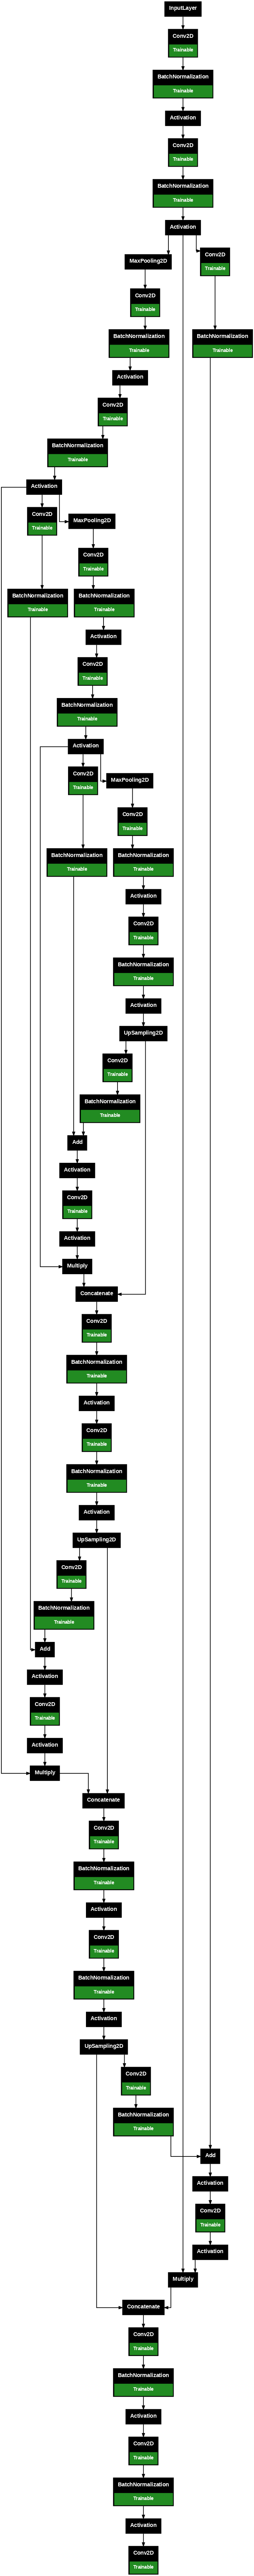

In [ ]:
# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

## 🛠️ Train and Save the Model

In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    min_delta=0.001,
    patience=patience,
    restore_best_weights=True
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6, verbose=1)
viz_callback = VizCallback(X_val[0], y_val[0])

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=300,
    validation_data=val_dataset,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_meanIoU = round(max(history['mean_iou'])* 100, 2)
print(f'Final Mean Intersection Over Union: {final_meanIoU}%')

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Epoch 1/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - loss: 0.9435 - mean_iou: 0.1469 - val_loss: 21.7418 - val_mean_iou: 0.0684 - learning_rate: 0.0010
Epoch 2/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - loss: 0.6880 - mean_iou: 0.1964 - val_loss: 6.1019 - val_mean_iou: 0.0543 - learning_rate: 0.0010
Epoch 3/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - loss: 0.6409 - mean_iou: 0.2119 - val_loss: 1.7470 - val_mean_iou: 0.0684 - learning_rate: 0.0010
Epoch 4/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - loss: 0.6047 - mean_iou: 0.2520 - val_loss: 2.8564 - val_mean_iou: 0.0685 - learning_rate: 0.0010
Epoch 5/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - loss: 0.5586 - mean_iou: 0.2886 - val_loss: 1.3845 - val_mean_iou: 0.1255 - learning_rate: 0.0010
Epoch 6/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - loss: 0.5462 - mean_iou: 0.3690 - val_loss: 0.9005 - val_mean_iou: 0.2140 - learning_rate: 0.0010
Epoch 7/300
71/71 ━━━━━━━━━━━━━━━━━━━━ 21s 292ms/step - loss: 0.5033 - mean_i

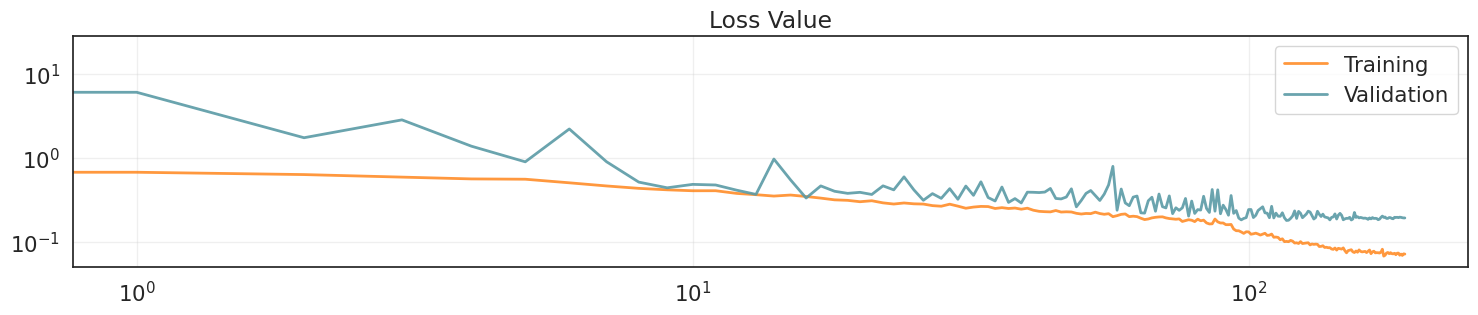

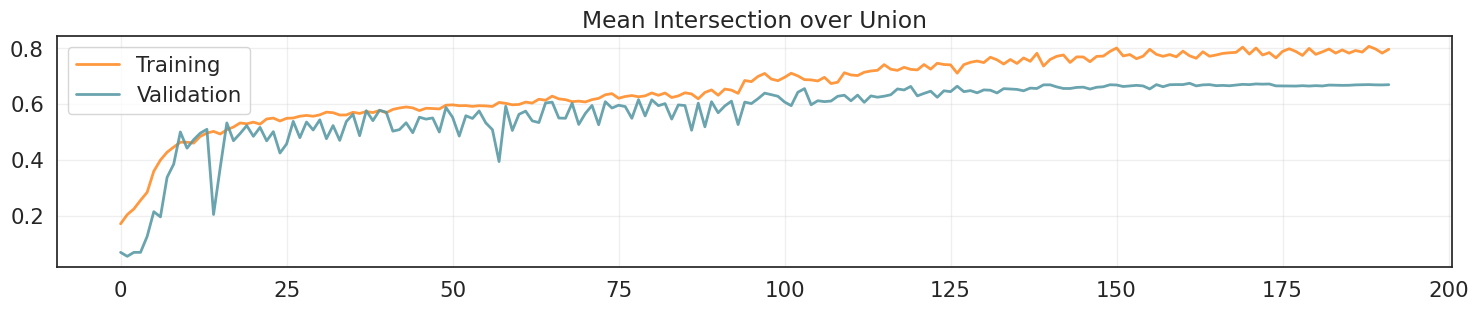

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.loglog(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.loglog(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Loss Value')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

print(f"Model saved to {model_filename}")

Model saved to UNet_67.38.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
%cd "/gdrive/MyDrive/Progetto AN2DL"
!mv "/gdrive/MyDrive/Progetto AN2DL/UNet_67.38.keras" "/gdrive/MyDrive/Progetto AN2DL/Submissions"
%cd "/gdrive/MyDrive/Progetto AN2DL/Submissions Davide"
!ls

/gdrive/.shortcut-targets-by-id/1E-vTKoRQdfaM-gJ1ejZEYjDrQK6K2Mmu/Progetto AN2DL
mv: cannot stat '/gdrive/MyDrive/Progetto AN2DL/UNet_59.19.keras': No such file or directory
/gdrive/.shortcut-targets-by-id/1E-vTKoRQdfaM-gJ1ejZEYjDrQK6K2Mmu/Progetto AN2DL/Submissions Davide
'(Discard) UNet_41.02 (Default Loss S-UNet).keras'
 model.png
 submission_UNet_32.09.csv
 submission_UNet_34.75.csv
 submission_UNet_39.04.csv
 submission_UNet_42.18.csv
 submission_UNet_43.22.csv
 submission_UNet_59.19.csv
 submission_UNet_61.86.csv
 submission_UNet_62.56.csv
 submission_UNet_62.76.csv
 submission_UNet_63.46.csv
 submission_UNet_65.14.csv
 submission_UNet_68.02.csv
 UNet_43.64.keras
 UNet_58.26.keras
 UNet_59.19.keras
 UNet_61.86.keras
 UNet_62.56.keras
 UNet_64.81.keras
 UNet_65.14.keras
'(Valid) UNet_39.04 (Custom Loss S-UNet No BN).keras'
'(Valid) UNet_43.22 (Custom Loss S-UNet).keras'


In [ ]:
preds = model.predict(test_dataset)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")


314/314 ━━━━━━━━━━━━━━━━━━━━ 35s 105ms/step
Predictions shape: (10022, 64, 128)


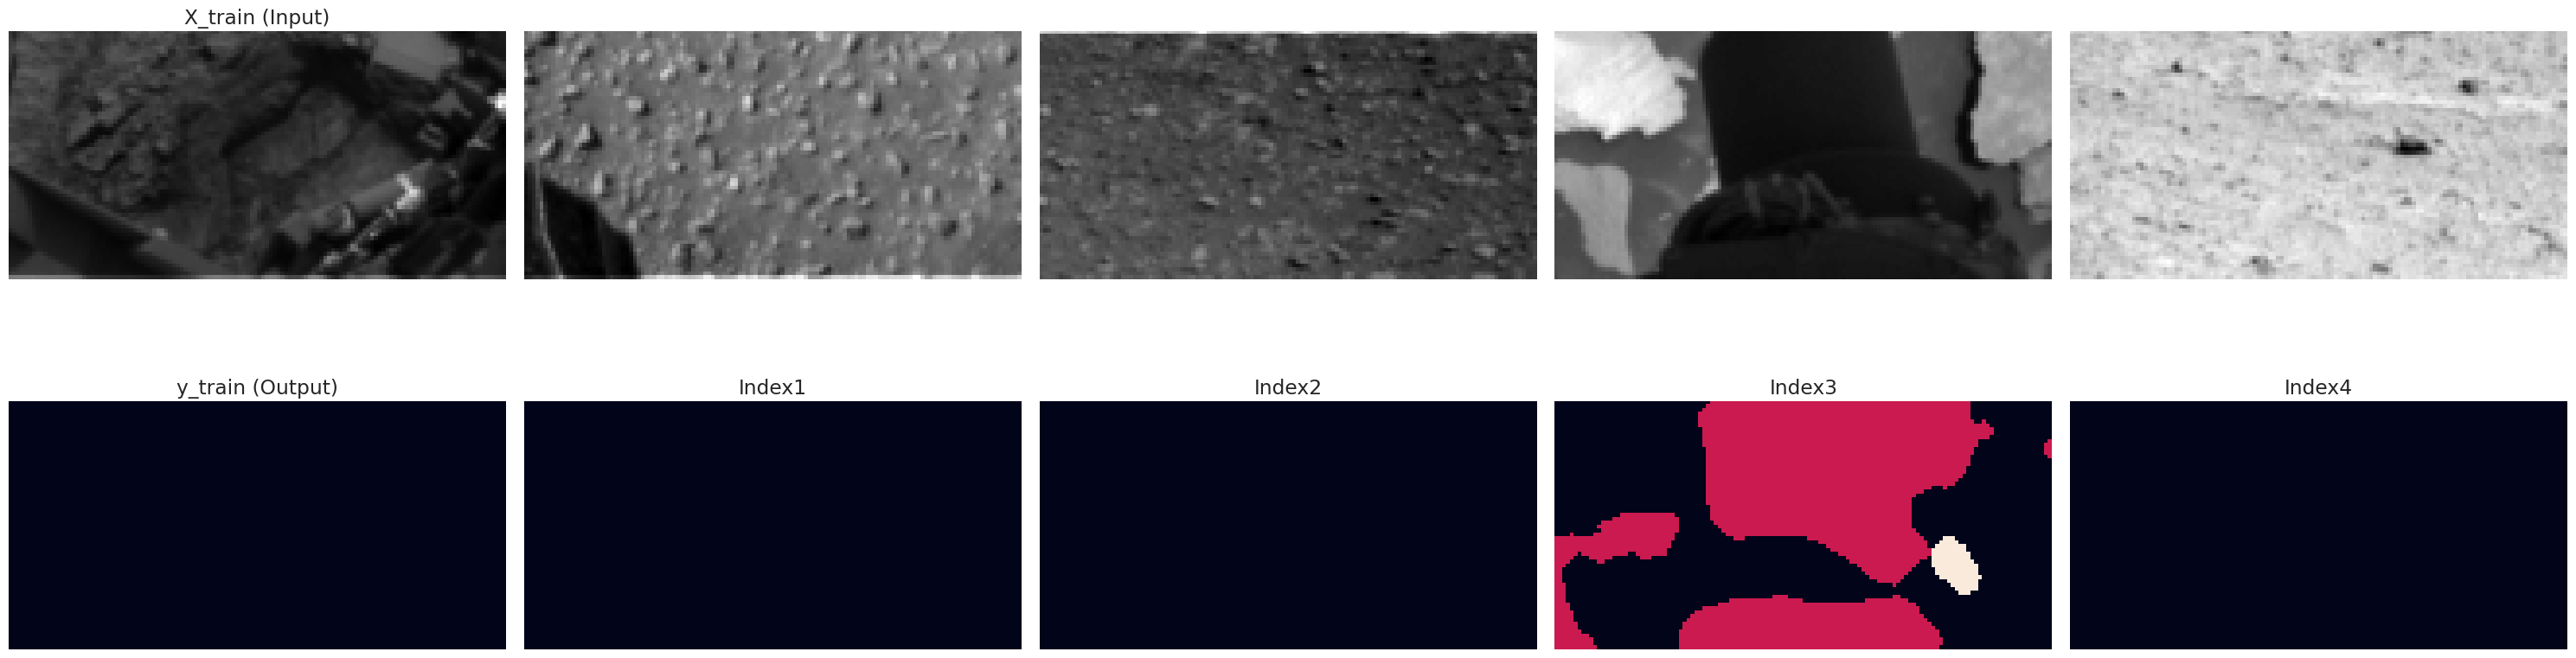

In [ ]:
# Genera 10 indici casuali univoci
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Seleziona le immagini e le etichette corrispondenti
X_samples = X_test[random_indices]
y_samples = preds[random_indices]

# Configura la figura
fig, axes = plt.subplots(2, num_samples, figsize=(30, 10))

# Mostra le immagini di X_train
for i, ax in enumerate(axes[0]):
    ax.imshow(X_samples[i], cmap='gray')
    ax.axis('off')

# Mostra le immagini o le etichette di y_train
for i, ax in enumerate(axes[1]):
    ax.imshow(y_samples[i])
    ax.set_title(f'Index{i}')
    ax.axis('off')

# Aggiungi titoli opzionali
axes[0][0].set_title("X_train (Input)")
axes[1][0].set_title("y_train (Output)")

plt.tight_layout()
plt.show()

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
del model

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```